## 目的
本ノートブックでは、畳み込みニューラルネットワーク(CNN)および敵対的生成ネットワーク(GAN)の学習に用いる学習データの作成を行う。



波形の生成に用いた理論モデルはSEOBNR(Effective-One-Body Numerical-Relativity Waveform Models for Spin-aligned Binary Black Holes)である。
SEOBNRは弱重力場でのポストニュートン展開(アインシュタイン方程式を全てのオーダーで解かずに
物質の速度の光速度に対する比を展開パラメータとして
方程式、計量を展開する手法)と強重力場での数値相対論を組み合わせたものであり、連星をなすブラックホールのスピンは-1から-1に制限されており、整列したスピンのみを対象としている。
また、歳差運動は考慮されていない。


In [9]:
%matplotlib inline
from pathlib import Path
from pycbc.waveform import get_td_waveform
import pylab
import numpy as np

import pycbc.noise
import pycbc.psd


# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1 
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096

距離を以下のようにして設定する。
まず次の３つの一様乱数を生成する。
\begin{equation}
\begin{cases}
\theta & (-1\leq \theta\leq 1) \\
\phi & (0\leq \phi\leq 2\pi) \\
r & (0 \leq r \leq 1)
\end{cases}
\end{equation}
これを用いて単位球内に一様に分布する点の座標(x,y,z)を、
以下のように求める。
\begin{equation}
\begin{cases}
x = r^{\frac{1}{3}}\sqrt{1-\theta^{2}}\cos\phi \\
y = r^{\frac{1}{3}}\sqrt{1-\theta^{2}}\sin\phi \\
z = r^{\frac{1}{3}}\theta
\end{cases}
\end{equation}
これらの座標に適切な値を乗算して距離を計算した。

In [3]:
xs =[]
ys=[]
zs=[]
rng = np.random.RandomState()
for _ in range(5000):
    theta = rng.uniform(-1,1)
    phi = rng.uniform(0,2*np.pi)
    r = rng.uniform(0, 1)
    x=r**(1/3)*(1-theta**2)*np.cos(phi)
    y=r**(1/3)*(1-theta**2)*np.sin(phi)
    z=r**(1/3)*theta
    xs.append(x)
    ys.append(y)
    zs.append(z)

distance=[]
for i in range(len(xs)):
    dis = np.sqrt(xs[i]**2 + ys[i]**2 + zs[i]**2)
    distance.append(dis)

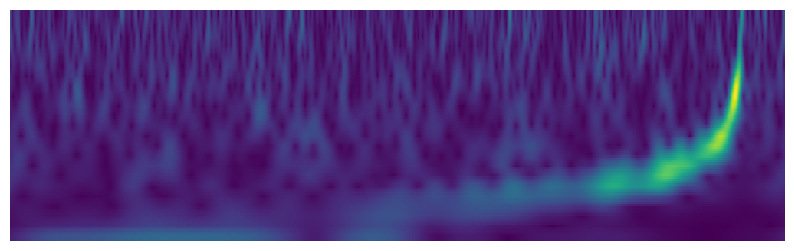

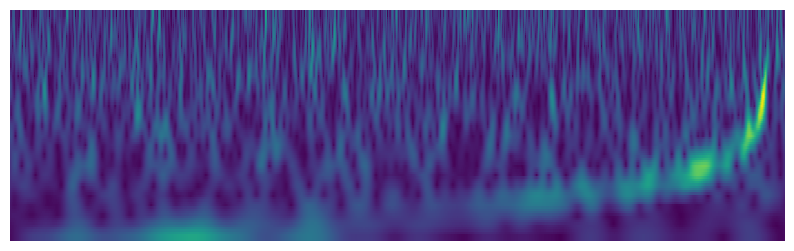

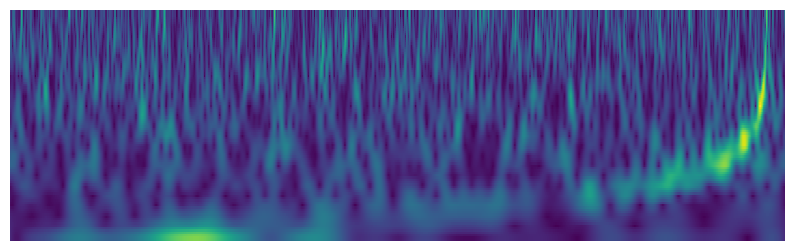

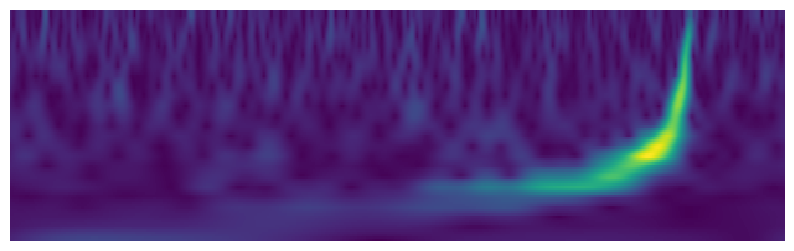

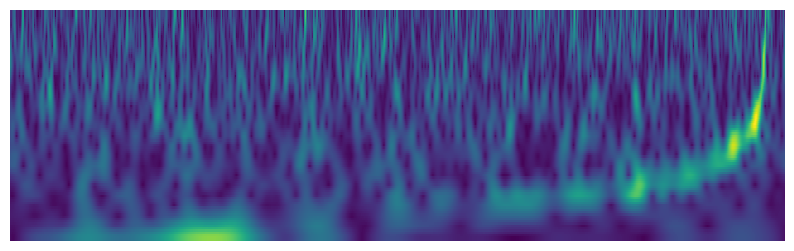

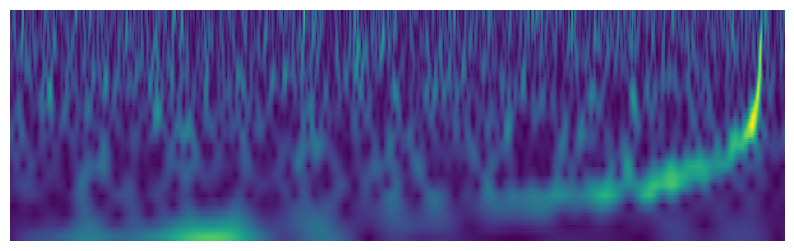

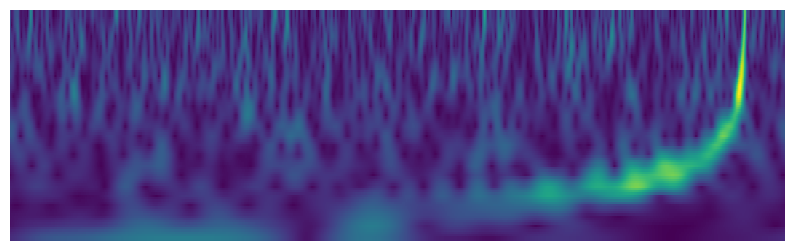

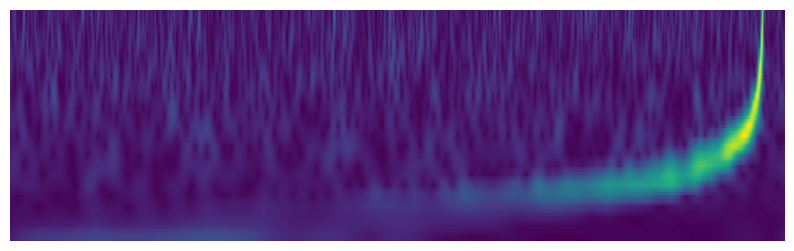

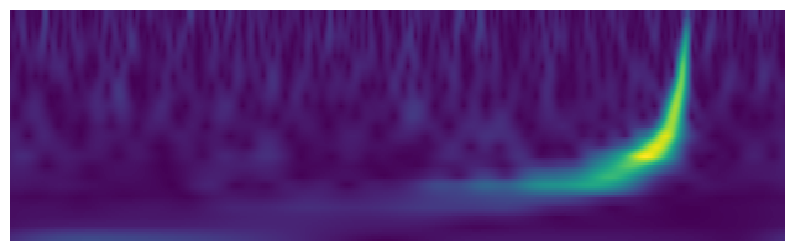

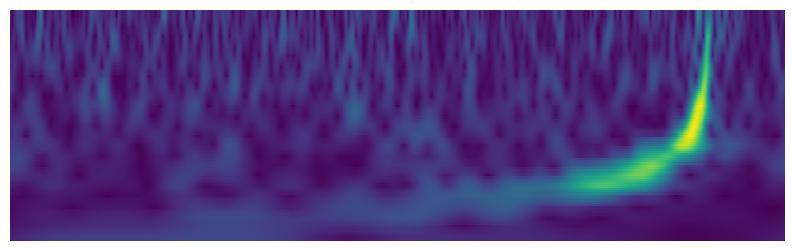

In [7]:
# num,hp2,hp3,path
import random
num = 10

a = 5
b = 30
c = 200
d = 1000
dist = 1000
np.random.seed()
Mass1 = (b - a) * np.random.rand(num) + a   #a以上b未満の乱数
Mass2 = (b - a) * np.random.rand(num) + a
distlist = list(map(lambda x: x *dist , distance))
for m1,m2,d,i in zip(Mass1,Mass2,distlist,range(num+1)):
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=d) 
    hp.start_time = 0
    ts = pycbc.noise.noise_from_psd(len(hp.sample_times), delta_t, psd, seed=127)
    hp2 = hp +ts
    hp3 = ts
    times,freqs,power = hp2.qtransform(0.001, logfsteps = 100,
                                             qrange=(8,8),
                                             frange=(30,512),)

    pylab.figure(figsize =[10,3])
    pylab.pcolormesh(times,freqs,power**0.5)  
    pylab.yscale('log')
    pylab.axis('off')
#    pylab.colorbar()
    pylab.show()
    # pylab.savefig("./data/%03.f"%(i)+".jpg")
    # pylab.close()